In [13]:
import warnings
warnings.filterwarnings("ignore")

# Import basic packages
import numpy as np
import pandas as pd
from pandas import datetime

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 8

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# Auto ARIMA
from pyramid.arima import auto_arima

In [14]:
train = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date')
store = pd.read_csv('store.csv')
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

### Exploratory Analysis

In [15]:
print("DataFrame Shape: ", train.shape)
train.head()

DataFrame Shape:  (1017209, 8)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1


**Short description:**
* Sales: the turnover for any given day (target variable).
* Customers: the number of customers on a given day.
* Open: an indicator for whether the store was open: 0 = closed, 1 = open.
* Promo: indicates whether a store is running a promo on that day.
* StateHoliday: indicates a state holiday. Normally all stores, with few * exceptions, are closed on state holidays.
* SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.


In [16]:
train.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

In [17]:
# Data Extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# Adding new variable
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].describe()


count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

**Note:** 
The new 'SalesPerCustomer' variable, we calculate, on average, how much customers spend at each store. From the summary table alone, we can see that across all stores, customers on average spend €9.49, with a 75% of customers spending €10.90 or less. This means that the majority of customers visiting Rossmann Stores spend less than €11, with few people making large purchases. We can also see that there are days when stores make €0.00. </p>

Let's visualise this using a boxplot.

Text(0.5,1,'Spend per Customer')

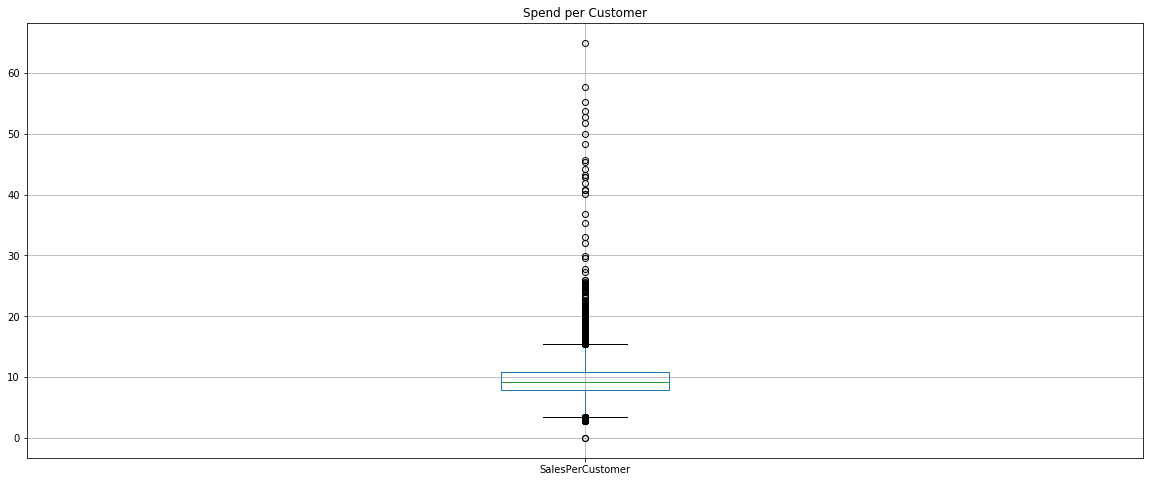

In [18]:
# Boxplot
train.boxplot(['SalesPerCustomer'])
plt.title('Spend per Customer')

Text(0.5,1,'Sales Distribution')

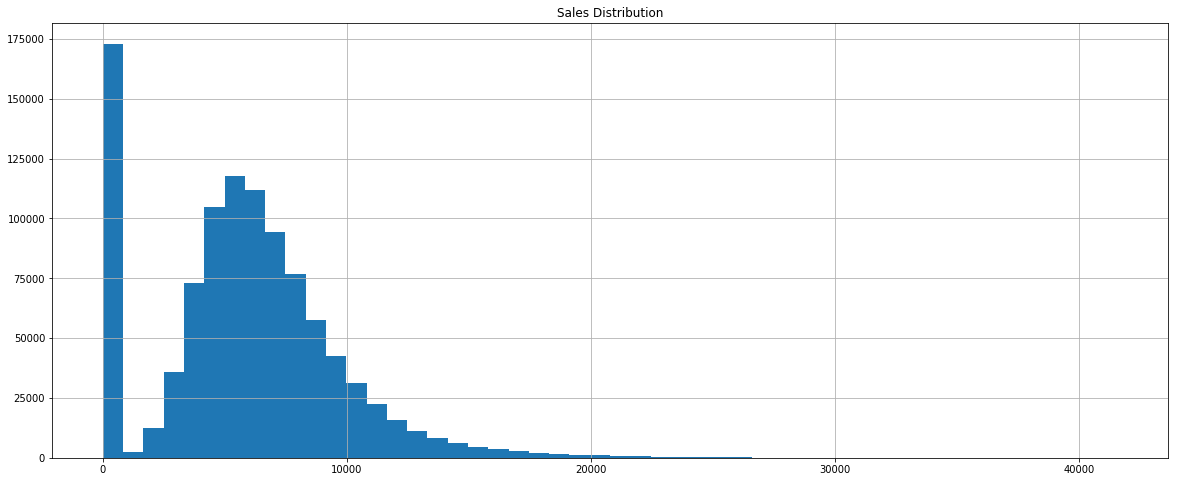

In [19]:
# Let's also check out the distribution
train['Sales'].hist(bins = 50, )
plt.title('Sales Distribution')

**Note: **Here, we see a near normal distribution with a significant number of sales/customer with €0.00.  Let's have a look what's going on here. Perhaps it's due to store closure?

### Missing Values and Store Closures

#### Closed stores and Zero Sales

In [20]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31    292          5      0          0     0      1            0   
2015-07-31    876          5      0          0     0      1            0   
2015-07-30    292          4      0          0     0      1            0   
2015-07-30    876          4      0          0     0      1            0   
2015-07-29    292          3      0          0     0      1            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear  SalesPerCustomer  
Date                                                                       
2015-07-31              1  2015      7   31          31               NaN  
2015-07-31              1  2015      7   31          31               NaN  
2015-07-30              1  2015      7   30          31               NaN  
2015-07-30              1  2015      7   30          31               NaN  
2015-07-29              1  2015      7   29          31               NaN

In [21]:
print("Number of stores that are closed and with zero sales: {}".format(len(train[(train.Open == 0) & (train.Sales == 0)])))

Number of stores that are closed and with zero sales: 172817


**Note:** There are about 172817 closed stores with zero sales in the data. This is approximately 10% of the entire dataset. Let's remove these so they dont unnecessarily bias the data.

In [22]:
# open stores with zero sales
zero_sales = train[(train.Open !=0) & (train.Sales == 0)]
print("Open Stores with €0.00 sales: {}".format(zero_sales.shape[0]))
zero_sales.head()

Open Stores with €0.00 sales: 54


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-05-15    971          5      0          0     1      0            0   
2015-03-26    674          4      0          0     1      0            0   
2015-02-05    699          4      0          0     1      1            0   
2014-10-01    708          3      0          0     1      1            0   
2014-09-22    357          1      0          0     1      0            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear  SalesPerCustomer  
Date                                                                       
2015-05-15              1  2015      5   15          20               NaN  
2015-03-26              0  2015      3   26          13               NaN  
2015-02-05              0  2015      2    5           6               NaN  
2014-10-01              0  2014     10    1          40               NaN  
2014-09-22              0  2014      9   22          39               NaN

**Note:** Interestingly, there are stores that are open but with €0.00 sales. One possible explanation for this may be store renovation, or other external factors.

In [23]:
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]
print("Final dataframe shape: {}".format(train.shape))

Final dataframe shape: (844338, 13)


### Store Dataframe

In [24]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [25]:
store['CompetitionOpenSinceYear'].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

In [26]:
train.Year.unique()

array([2015, 2014, 2013])

In [27]:
store.shape

(1115, 10)

**Column Descriptions: **
* Store: a unique Id for each store
* StoreType: differentiates between 4 different store models: a, b, c, d
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [28]:
# Checking for missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

**Note:** There are quite a few variables with missing data. Let's start with CompetitionDistance.

In [29]:
# Null values Competition Distance
store[pd.isnull(store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

**Note: **Cross checking these stores with the train table, it seems all three of these stores are active stores, and have regular sales. It would suggest then that the NaNs in this table are missing values. So let's fill these with the median value.

In [30]:
# Fill NaN
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [31]:
# store[pd.isnull(store.Promo2SinceWeek)]

In [32]:
# # no promo/information
# _ = store[pd.isnull(store.Promo2SinceWeek)]
# _[_.Promo2 == 0]

**Note:** For the remainder of the missing values, we simply have no information on these. There are a number of ways in which we can deal with missing data. The most aggressive way would be remove these observations. However, we would be losing a lot of information this way. </p>

Another way to deal with missing values would be filling with '0'. But given that the missing values in the columns are year/month values, this would not be ideal either. </p>

So instead, let's try to fill with median values.


In [33]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [34]:
store['CompetitionOpenSinceMonth'].fillna(7, inplace=True) # fill missing data with July (middle of year)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(), inplace=True)

In [35]:
# Joining the store and train datasets
train_store = pd.merge(train, store, how='inner', on = 'Store')
print("train_store shape: {}".format(train_store.shape))
train_store.head()

train_store shape: (844338, 22)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Year  Month      ...        SalesPerCustomer  StoreType  \
0              1  2015      7      ...                9.482883          c   
1              1  2015      7      ...                9.194139          c   
2              1  2015      7      ...                9.143403          c   
3              1  2015      7      ...                8.948214          c   
4              1  2015      7      ...                9.970588          c   

   Assortment CompetitionDistance CompetitionOpenSinceMonth  \
0           a              1270.0                       9.0   
1           a              1270.0                       9.0   
2           a              1270.0                       9.0   
3           a              1270.0                       9.0   
4           a              1270.0                       9.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2008.0       0              NaN              NaN   
2                    2008.0       0              NaN              NaN   
3                    2008.0       0              NaN              NaN   
4                    2008.0       0              NaN              NaN   

   PromoInterval  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 22 columns]

### Now, let's look at the how the store types affect sales

In [36]:
train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [37]:
train_store.groupby('StoreType')['Sales'].describe()

count          mean          std     min      25%     50%  \
StoreType                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   

                75%      max  
StoreType                     
a           8406.00  41551.0  
b          13184.25  38722.0  
c           8349.25  31448.0  
d           8123.25  38037.0

**Note:** From this summary table, we can see that StoreType b has the highest mean sales with 75% of StoreType b stores having sales figures above €10000. This is much higher than the sales figures for StoreTypes a, c, and d. But also note that we have much fewer observations for StoreType b. 

In [38]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum().sort_values('Sales', ascending=False)

Customers       Sales
StoreType                       
a          363541431  3165334859
d          156904995  1765392943
c           92129705   783221426
b           31465616   159231395

**Note:** But when we look at total sales for each of the StoreTypes, however, we can see that StoreType b has the lowest total sales, with StoreType A having total sales almost 20x that of StoreType B.

### Next, let's visualise the sales trends by Month and by Day of Week

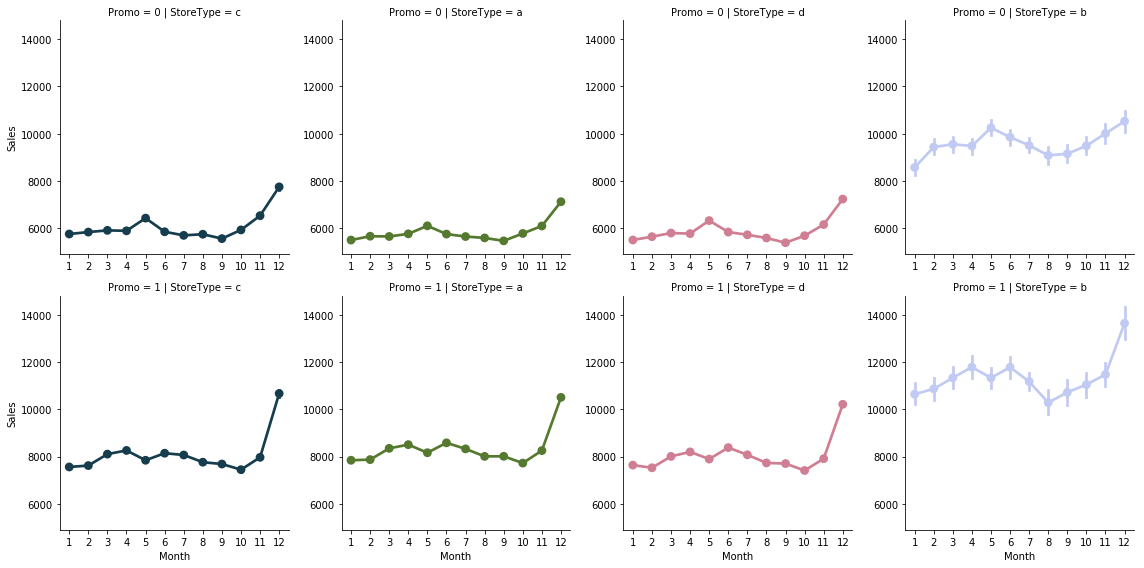

In [39]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = "cubehelix",
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               ) 

**Note: ** From this graph, we can see that sales are higher when stores are running promotions.

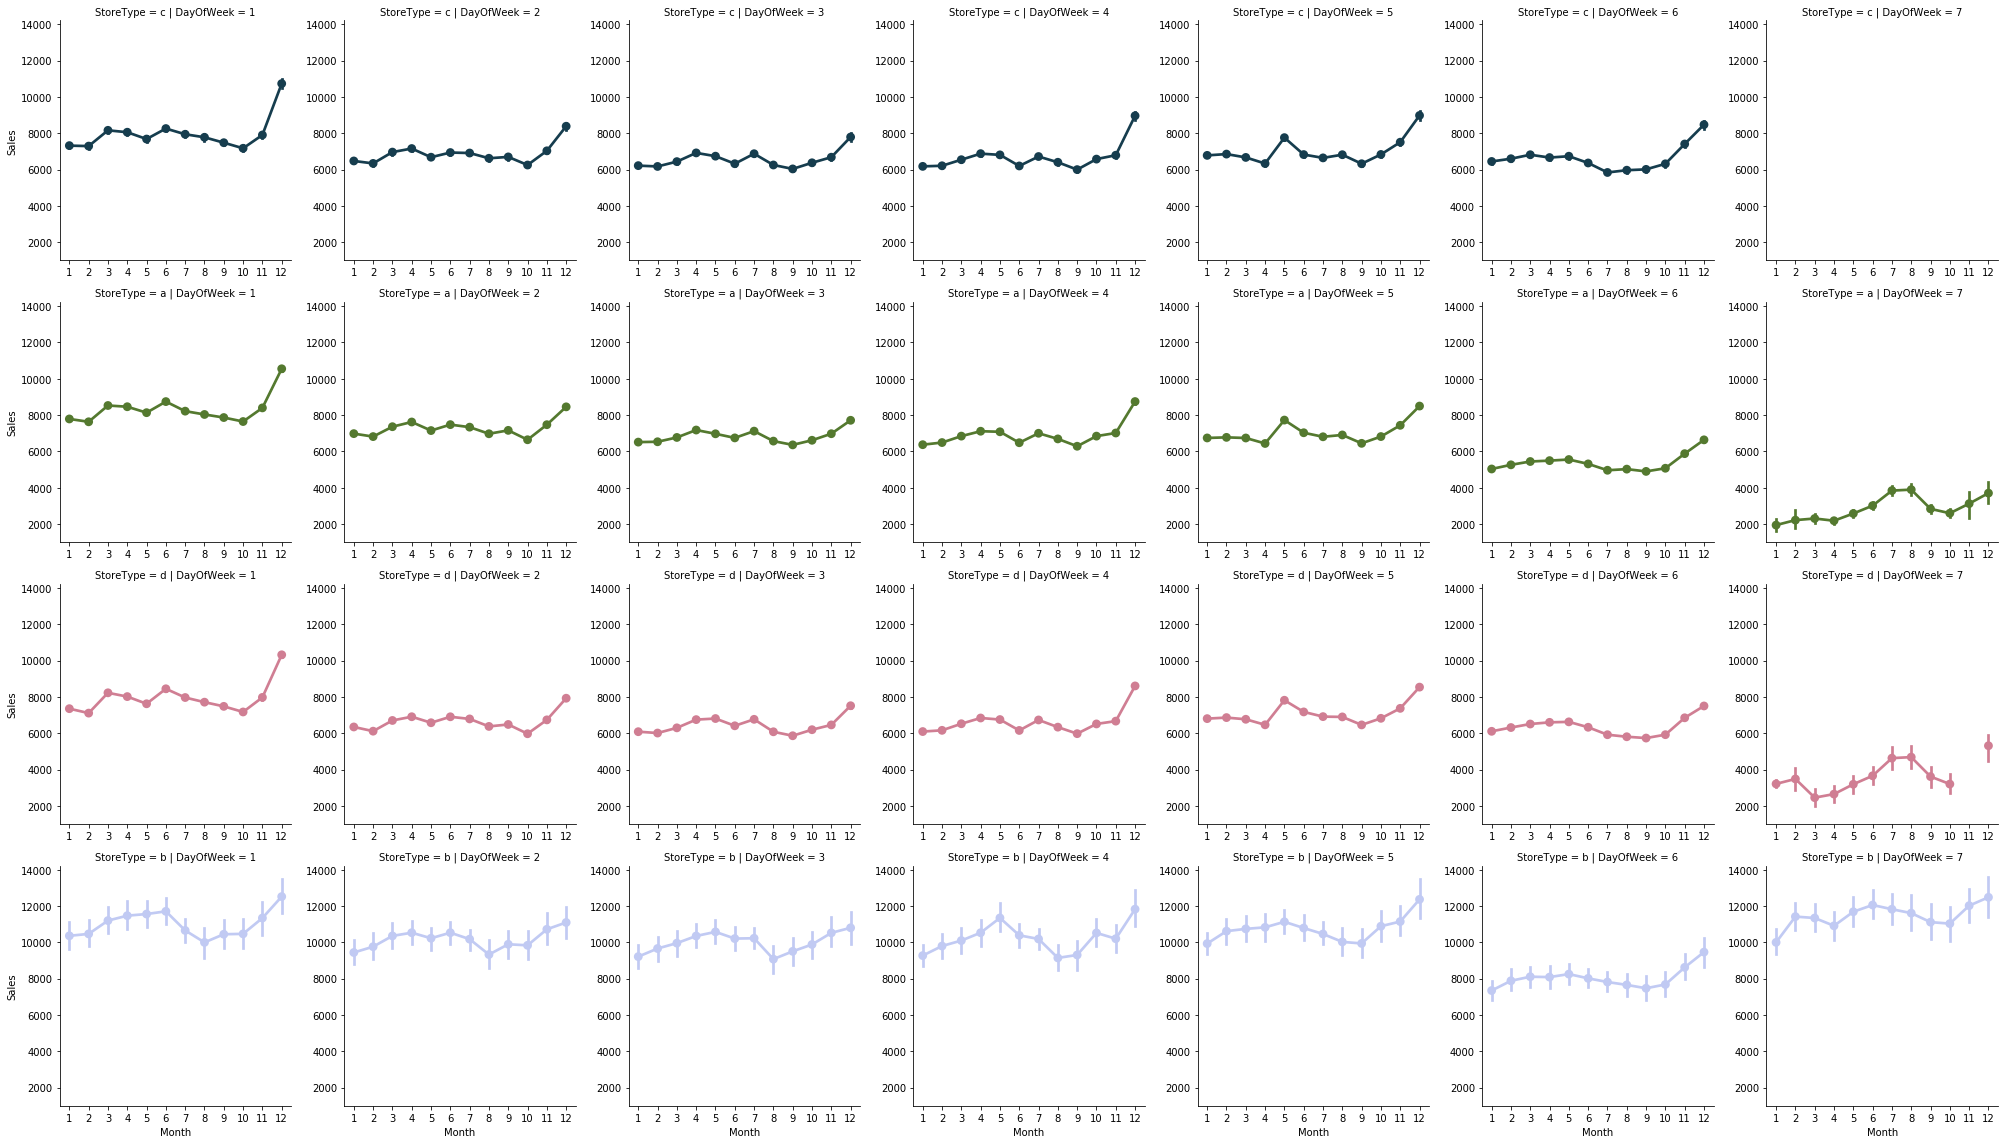

In [40]:
# customers
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = "cubehelix",
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               ) 

**Note: ** There are lots of interesting information on this plot. Full explanation is beyond the remit of this notebook. Just a few trends quickly though:
* StoreType C appears to be closed on Sundays
* Storetype D seem to have closed their doors on Sundays in November
* For StoreTypes A and D, sales are lowest on Sundays, whereas for StoreType B, sales are lowest on Saturdays

### To finish off our exploratory analysis, let's have a look at promo variables

In [41]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12* (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo Open time 
train_store['PromoOpen'] = 12*(train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4



In [42]:
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

Sales    Customers  PromoOpen  CompetitionOpen
StoreType                                                       
a           6925.697986   795.422370  23.514536        56.507971
b          10233.380141  2022.211825  12.880372        59.228085
c           6933.126425   815.538073  28.064913        57.783691
d           6822.300064   606.353935  26.038356        51.948850

**Note:** Here, we see that while StoreType b have had competetions for the period of time, they had the fewest months in which promotions were ran. This is in contrast to StoreType d where for half the time that this type of store has been open it has been running promotions. </p>

Considering this new information with our factorplots, even though StoreType d had the longest running promotions, it actually performs on par with StoreTypes c and c.

### Correlation Analysis

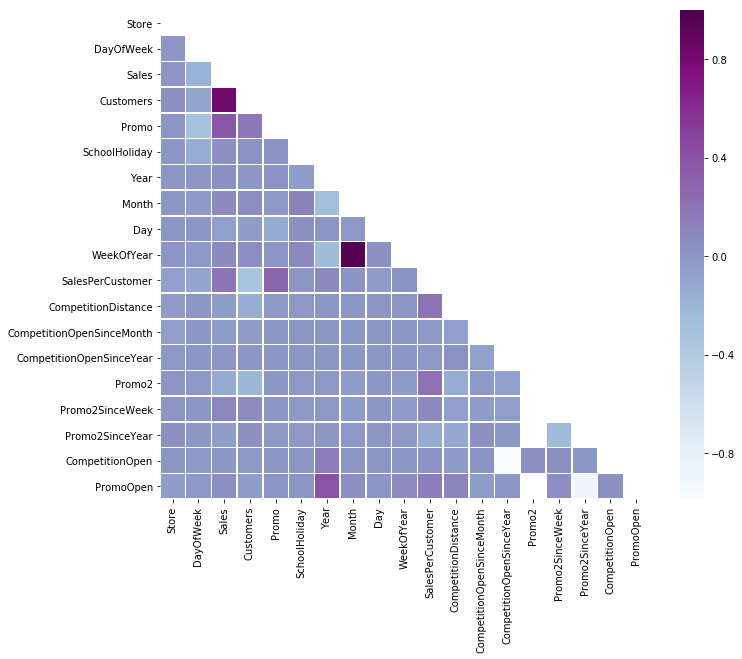

In [43]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

**Note:** At a quick glance, some features seem to be correlated with each other
* sales, promo
* sales, customer
* SalesPerCustomer, Sales
* SalesPerCustomer, Promo2
* CompetitionDistance, SalesPercustomer

Clearly promotions have a lot to do with sales!!! Let's explore this some more.

In [44]:
# group by StoreType, Promo, Promo2
pd.DataFrame(train_store.groupby(['StoreType','Promo', 'Promo2'])['Sales'].mean())

Sales
StoreType Promo Promo2              
a         0     0        6102.371493
                1        5473.860548
          1     0        8538.298356
                1        8035.806221
b         0     0       10511.458662
                1        7240.801153
          1     0       12165.463888
                1        9209.755685
c         0     0        6728.066370
                1        5324.450380
          1     0        8809.760601
                1        7265.312892
d         0     0        6154.165443
                1        5629.857267
          1     0        8395.900716
                1        7731.786972

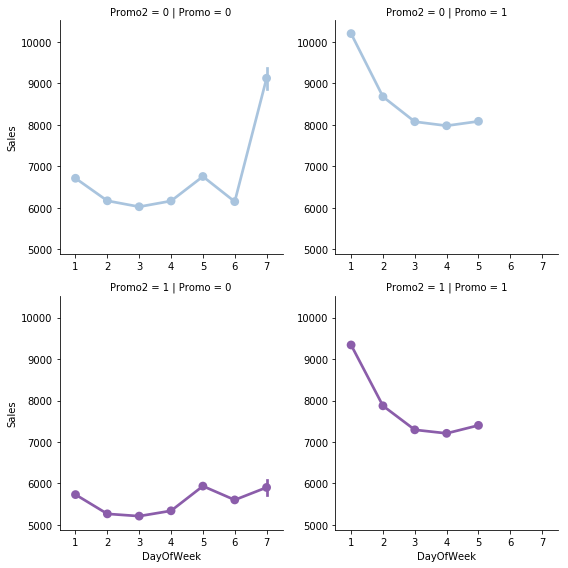

In [45]:
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = "BuPu") 

**Observations:** Running 2 promotions at the same time tends to decrease overall sales. However, running only store-wide promotion seems to boost sales. This seems to be true for all Storetypes. </p>

Another thing worth noting is that stores that run store-wide promotions appear to be closed on weekends.

## Preliminary Findings of Exploratory Data Analysis
* StoreType A is the highest grossing across the four StoreTypes drawing in the most customers
* While StoreType B has the highest sales on average, they actually bring in the least amount of revenue
* Promotions boost sales to a certain degree, but multiple campaigns can work against the company
* When there is a promotion, most of the sales happen on Monday
* When there are no promotions, Sundays have the highest sales

____

## Now, Let's have a look at some Time Series Data

In [46]:
data = pd.read_csv('train.csv', 
                   parse_dates = True, 
                   index_col='Date')

In [47]:
data.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

In [48]:
data = data[data['Sales'] !=0] # making sure that there are no rows with €0.00 sales which could bias the data

In [49]:
# Creating a function for testing stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # detrmine rolling statistics
    rolmean = pd.rolling_mean(timeseries, window = 12)
    rolstd = pd.rolling_std(timeseries, window = 12)
    
    #plot rolling statistics:
    plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='blue', label = 'Original')
    mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 'Number of Obsevations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [50]:
ts = data['Sales'].resample('D').mean() # Grabbing only 'Sales' column, and summing data by day

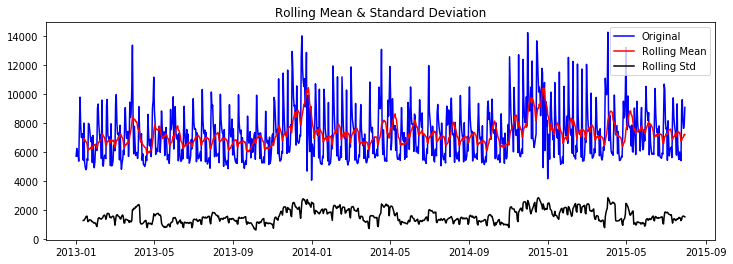

Results of Dickey-Fuller Test:
Test Statistic                 -5.416892
p-value                         0.000003
#Lags Used                     17.000000
Number of Obsevations Used    924.000000
Critical Value (1%)            -3.437447
Critical Value (5%)            -2.864673
Critical Value (10%)           -2.568438
dtype: float64


In [51]:
test_stationarity(ts)

**Notes: ** Dickey-Fuller test tests for stionarity. The p-value is very small indicating that there only a very slight chance that the data is not stationary. Therefore you can reject the null hypothesis and assume the data to be stationary.

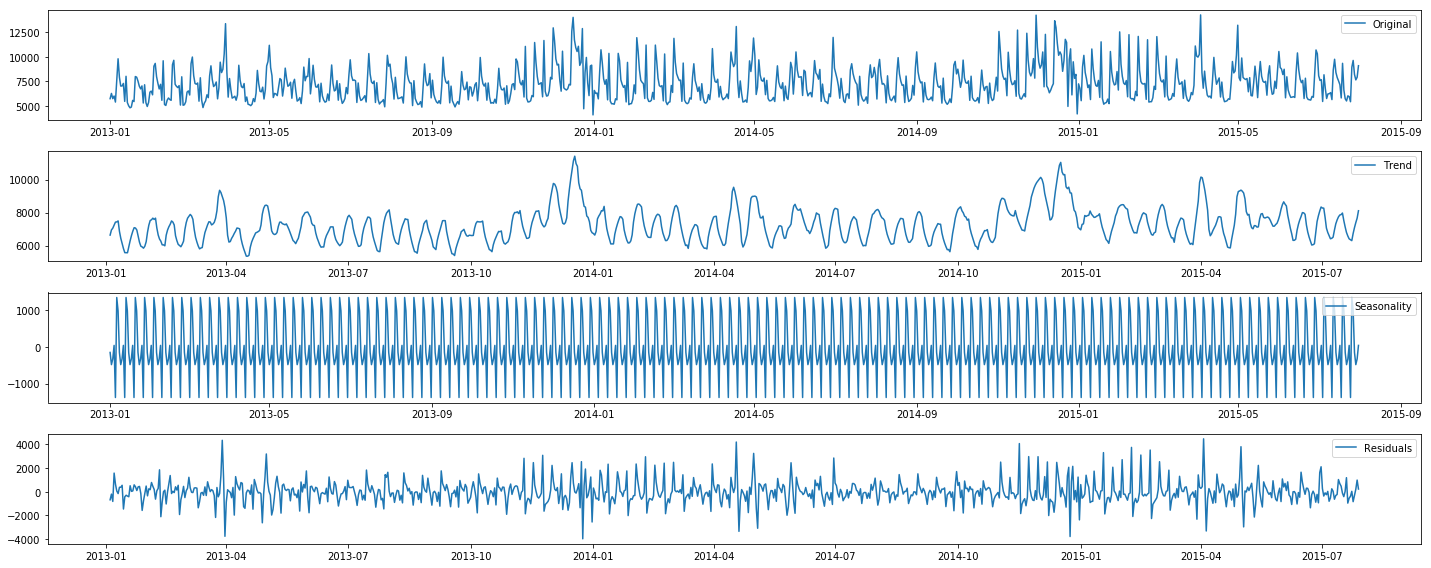

In [52]:
# Let's decompose the model however, and plot it.

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (20, 8))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**Note: ** Here we can see that the trend, seasonality are separated out from data and we can model the residuals.  When we look at the trend, we see a recurring pattern.  We see peaks anomalies in April, as well, over the Christmas period. This pattern recurs every year. We also see weekly patterns in the data. These also coincide with with major holidays.

In [53]:
# ts_decompose = residual
# ts_decompose.dropna(inplace=True)
# test_stationarity(ts_decompose)

## Forecasting Time Series - ARIMA

## Data Exploration

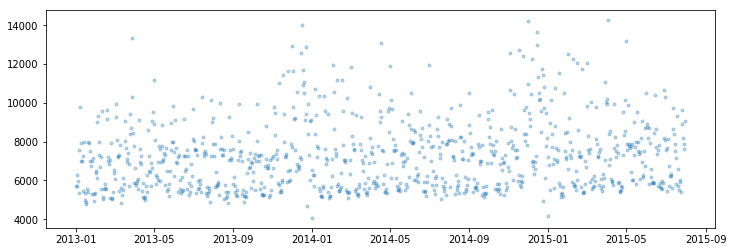

In [54]:
plt.figure(figsize=(12, 4))
plt.plot(ts, marker='.', linestyle='none', alpha=0.3)
# plt.plot(ts.values.mean())

**Note: ** As we have sen before, we see higher sales over christmas periods as well a smaller peak around April/May time.

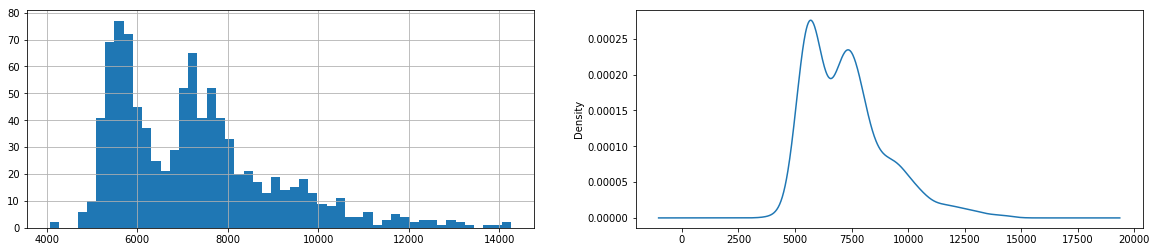

In [55]:
# figure for subplots
plt.figure(figsize = (20, 4))
# acf and pacf for All data
plt.subplot(121); ts.hist(bins = 50)
plt.subplot(122); ts.plot(kind='kde')


Here, we see that the distribution is bimodal.

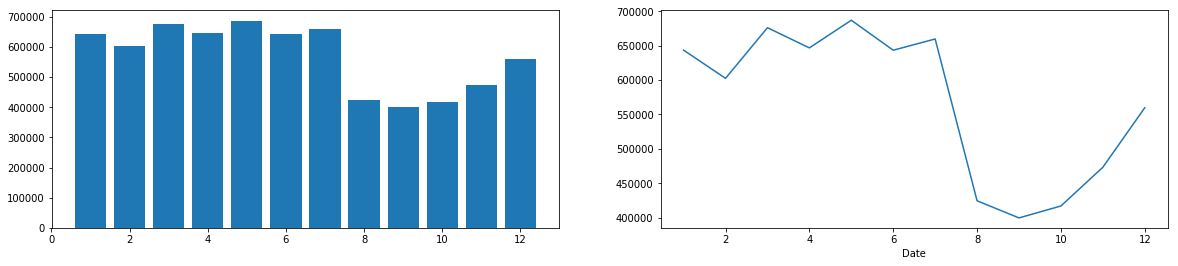

In [56]:
ts_m = ts.groupby(ts.index.month).sum()

plt.figure(figsize=(20,4))
plt.subplot(121); plt.bar(ts_m.index, ts_m.values)
plt.subplot(122); ts.groupby(ts.index.month).sum().plot()

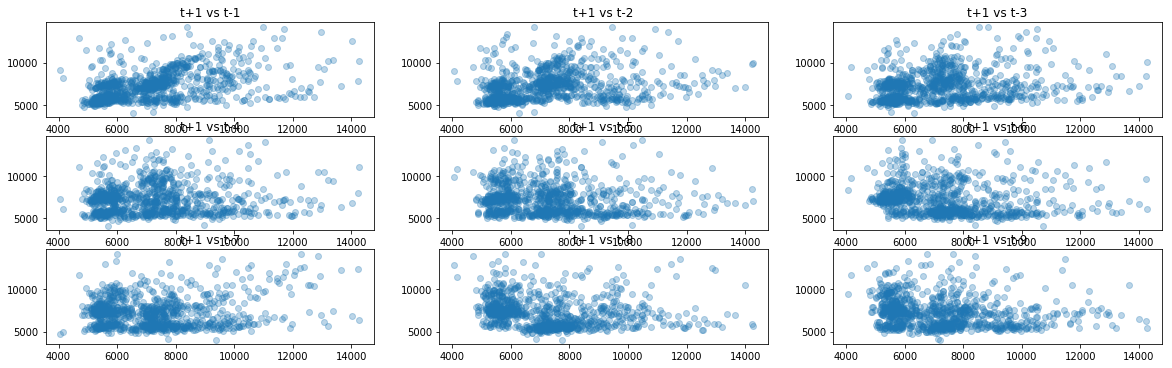

In [57]:
values = pd.DataFrame(ts.values)
lags = 9
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(430 + i)
	ax.set_title('t+1 vs t-' + str(i))
	plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values, alpha=0.3)
plt.show()

### Let's have a look at the acf and pacf plots

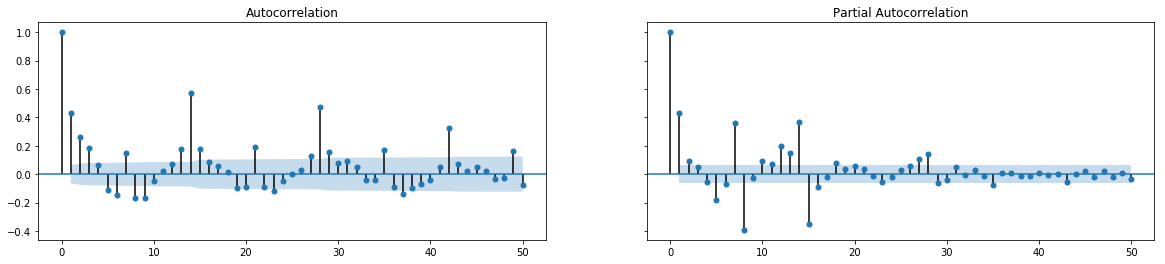

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (20, 4))
fig = plot_acf(ts, lags = 50, ax = ax1)
fig = plot_pacf(ts, lags = 50, ax = ax2)

**Note: ** From this plot, we can see that p = 2, and q = 1. We also see that the spikes on the acf plot every 14 days.

### ARIMA Model
#### Let's use auto.arima to find the best model

In [59]:
from statsmodels.tsa.arima_model import ARIMA
from pyramid.arima import auto_arima
import itertools  

In [60]:
stepwise_model = auto_arima(ts, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=16405.827, BIC=16429.998, Fit time=3.791 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=17340.321, BIC=17349.989, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=16953.838, BIC=16973.175, Fit time=1.342 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=16516.568, BIC=16535.904, Fit time=1.629 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=16408.611, BIC=16437.616, Fit time=4.205 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=16994.400, BIC=17013.736, Fit time=0.713 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=16552.019, BIC=16581.024, Fit time=10.873 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=16408.155, BIC=16441.993, Fit time=14.591 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=16400.736, BIC=16429.740, Fit time=3.915 seconds
Fit ARIM

In [61]:
stepwise_model

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

### Train Test Split

In [62]:
train = ts[:847]
test = ts[847:]
# len(train)+len(test)

In [63]:
# train = ts[:int(len(ts)*.7)]
# test = ts[int(len(ts)*.7):]

In [64]:
future_forecast = stepwise_model.predict(n_periods=len(test))
print(future_forecast[-10:])

[7355.77603241 7340.04028654 7300.84796413 7554.20640046 7415.53360626
 7578.68131099 7512.40741775 7382.5087817  7595.62949015 7397.04663632]


In [65]:
future_forecast = pd.DataFrame({"Date": test.index, "y_pred": future_forecast})

[]

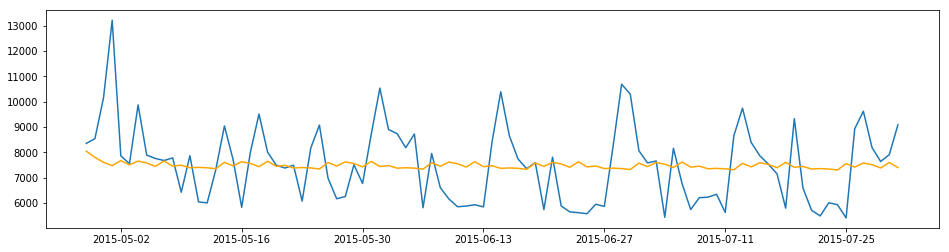

In [66]:
plt.figure(figsize=(16,4))
plt.plot(test)
# plt.plot(train, color = 'blue')
plt.plot(future_forecast.set_index('Date'), color='orange')
plt.plot()

# plt.plot(train)
# plt.plot(res, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-test)**2))

**Note: ** Clearly this is a bad prediction model. It fails to capture may of the seasonality in the dataset. There are cases when auto_arima does not capture the best model.

### Evaluate the Model

In [67]:

# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("mape: {}".format(mean_absolute_percentage_error(future_forecast['y_pred'], test.values)))

mape: 15.787123953478414


**Note :** As we suspected, the model did not capture the data well - it has an error rate of 15%

**Let's try tod this another way. One reason for this may be that our model does not capture public holidays.**

##########################################################################

# fbProphet

In [68]:
train = pd.read_csv('train.csv', 
                   parse_dates = True, 
                   index_col='Date')

In [69]:
data = pd.DataFrame(ts).reset_index()
data.columns = ['ds', 'y']
data.head(2)

ds            y
0 2013-01-01  5719.705882
1 2013-01-02  6255.471647

In [70]:
train.reset_index(inplace=True)

In [71]:
# create holidays dataframe
state_dates = train[(train.StateHoliday == 'a') | (train.StateHoliday == 'b') | (train.StateHoliday == 'c')].loc[:, 'Date'].values
# school_dates = train[train.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates).unique(),
                      'lower_window': -5,
                      'upper_window': 0
                     })
# school = pd.DataFrame({'holiday': 'school_holiday',
#                       'ds': pd.to_datetime(school_dates),
#                       'lower_window': -5,
#                       'upper_window': 0
#                       })

# holidays = pd.concat((state, school))      
# holidays.head()
state.head()

ds        holiday  lower_window  upper_window
0 2015-06-04  state_holiday            -5             0
1 2015-05-25  state_holiday            -5             0
2 2015-05-14  state_holiday            -5             0
3 2015-05-01  state_holiday            -5             0
4 2015-04-06  state_holiday            -5             0

In [72]:
# len(data)

In [73]:
train_set = data[:706]
test_set = data[706:]
print(len(test_set)+len(train_set))

942


In [74]:
model=Prophet(interval_width = 0.95, 
                   holidays = state)
model.fit(train_set)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
future=model.make_future_dataframe(periods = len(test_set))
future.tail(7)

ds
935 2015-07-25
936 2015-07-26
937 2015-07-27
938 2015-07-28
939 2015-07-29
940 2015-07-30
941 2015-07-31

In [76]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower    yhat_upper
937 2015-07-27  8552.335226  5792.915758  11376.616799
938 2015-07-28  7436.728484  4678.397672  10269.315642
939 2015-07-29  7222.865073  4378.070304  10052.159035
940 2015-07-30  7295.847668  4315.232971  10109.562487
941 2015-07-31  7648.058957  4799.929416  10321.447799

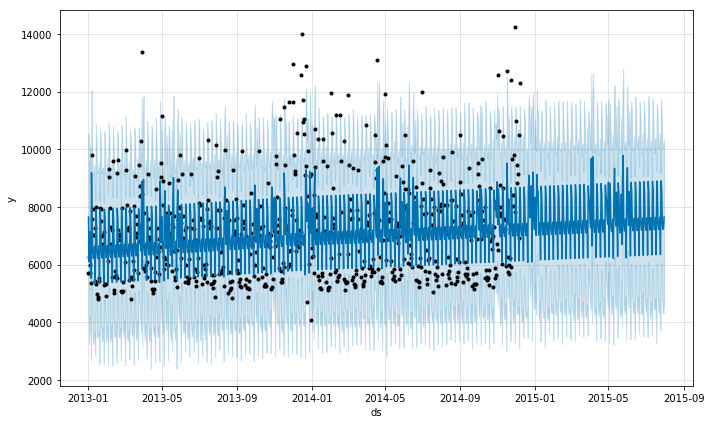

In [77]:
fig1 = model.plot(forecast)

In [78]:
# forecast[(forecast['state'] + forecast['school']).abs() > 0]\
# [['ds', 'state', 'school']][-10:]

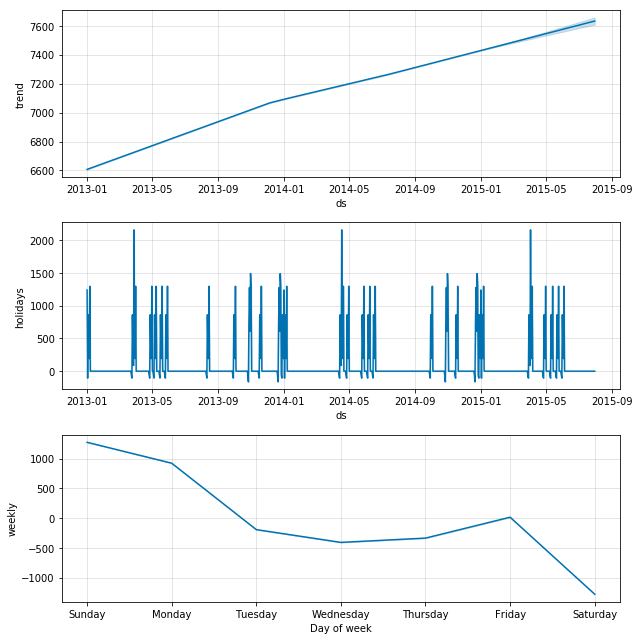

In [79]:
fig2 = model.plot_components(forecast)

**Observations: **
* The Holiday plot reveals that holidays positively impact sales for Rossmann
* The weekly trend reveals that Sunday and Monday positive impacts the sales trend, whereas Tuesday to Thursdays negatively 

But at this point, we can see that there is still quite a lot of noise in the model. Given that Rossmann store are located all across Germany, there is reason to believe that other factors such as location, geography, population density may impact sales. While the dataset does not provide information as to the geographical location of the Rossmann stores, we can try to see if we can determina trends by looking at each of the storetypes separately

### Diagnostic

In [80]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, period = '30 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 12 forecasts with cutoffs between 2013-10-13 00:00:00 and 2014-09-08 00:00:00


ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2013-10-14  7632.562558  5343.573227  9840.561961  5893.636771 2013-10-13
1 2013-10-15  6618.182740  4316.742739  9029.571267  5259.553363 2013-10-13
2 2013-10-16  6419.407590  4264.391728  8842.025832  5321.828700 2013-10-13
3 2013-10-17  6393.829002  4005.021694  8649.728156  5256.648430 2013-10-13
4 2013-10-18  6891.734768  4716.743065  9285.306290  5667.774888 2013-10-13

In [81]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse          mae      mape  coverage
818  9 days  3.063996e+06  1750.427450  1368.284463  0.187036  0.898148
369 10 days  3.037448e+06  1742.827663  1355.848368  0.184831  0.898148
909 10 days  3.034342e+06  1741.936161  1354.616884  0.184984  0.898148
549 10 days  3.030972e+06  1740.968574  1353.749529  0.183933  0.898148
639 10 days  3.000385e+06  1732.161875  1337.617188  0.180863  0.898148

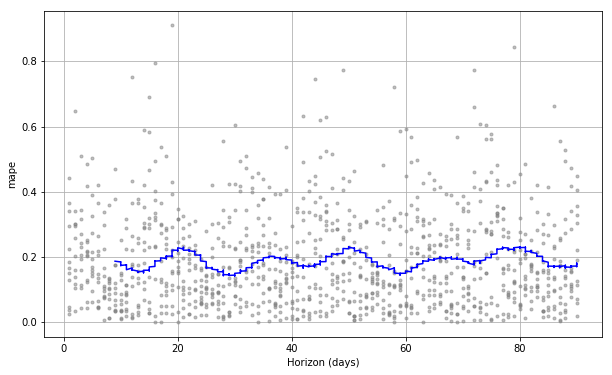

In [82]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

# By StoreTypes

In [83]:
# train.reset_index(inplace=True)
train.head(2)

Date  Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0 2015-07-31      1          5   5263        555     1      1            0   
1 2015-07-31      2          5   6064        625     1      1            0   

   SchoolHoliday  
0              1  
1              1

In [84]:
train = train[(train['Sales'] != 0) & (train['Open'] != 0)]

In [85]:
TrainStore = pd.merge(train, store, how='inner', on = 'Store').set_index('Date')

In [74]:
# Outcome variable should be of dtype=float
# TrainStore['Sales'] = TrainStore['Sales'] * 1.0

In [112]:
Sales_A = TrainStore[TrainStore['StoreType'] == 'a']['Sales']
Sales_B = TrainStore[TrainStore['StoreType'] == 'b']['Sales']
Sales_C = TrainStore[TrainStore['StoreType'] == 'c']['Sales']
Sales_D = TrainStore[TrainStore['StoreType'] == 'd']['Sales']

In [76]:
TrainStore.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### Daily Trend

In [77]:
# f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
# Sales_A.resample('D').sum().plot(ax = ax1)
# Sales_B.resample('D').sum().plot(ax = ax2)
# Sales_C.resample('D').sum().plot(ax = ax3)
# Sales_D.resample('D').sum().plot(ax = ax4)
# plt.title('Time Series Plots by StoreType')

### Seasonality

Text(0.5,1,'Time Series Plots by StoreType')

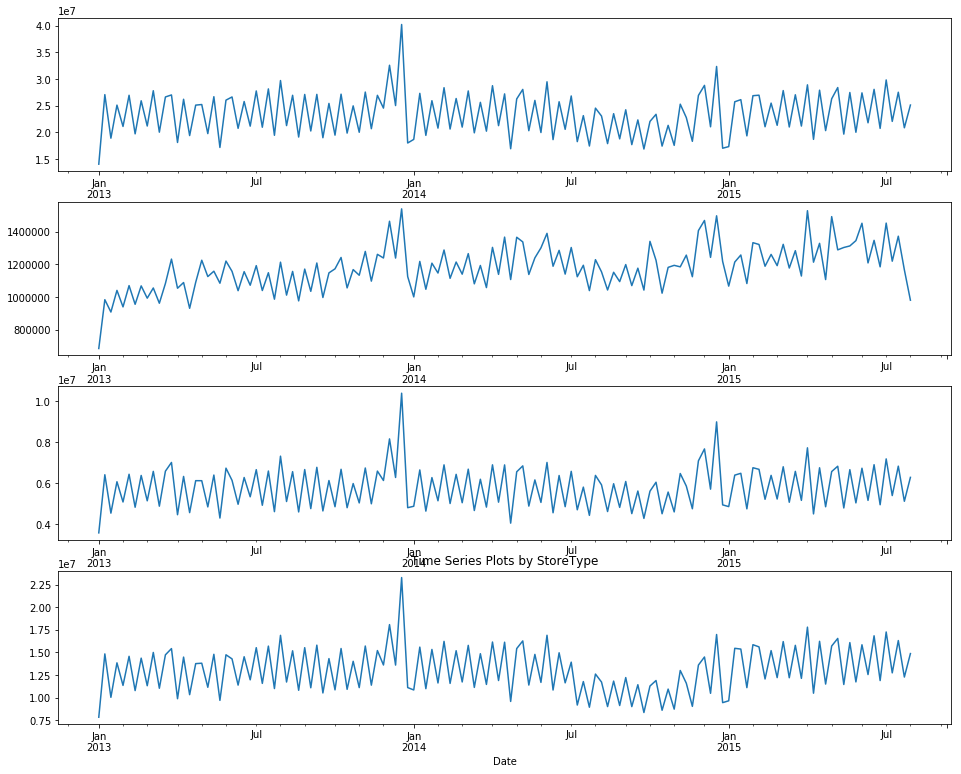

In [78]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (16, 13))
Sales_A.resample('W').sum().plot(ax = ax1)
Sales_B.resample('W').sum().plot(ax = ax2)
Sales_C.resample('W').sum().plot(ax = ax3)
Sales_D.resample('W').sum().plot(ax = ax4)
plt.title('Time Series Plots by StoreType')

**Note: ** As we have seen before, there are seasonality in the data, but we do not see evidence of trends - except perhaps for StoreType B. We can run the Dickie Fuller test to confirm this observation.

## StoreType A

In [86]:
# # importing data
# df = pd.read_csv("train.csv")

In [87]:
# remove closed stores and those with no sales
# df = TrainStore[(TrainStore["Open"] != 0) & (TrainStore['Sales'] != 0)]

In [88]:
# sales for the store number 7 (StoreType A)
sales = TrainStore[TrainStore['StoreType'] == 'a']['Sales']

In [82]:
# sales.reset_index(inplace=True)
sales = pd.DataFrame(sales).reset_index()

In [83]:
sales.columns = ['ds', 'y']

In [84]:
# from the prophet documentation every variables should have specific names
# sales = sales.rename(columns = {'Date': 'ds',
#                                 'Sales': 'y'})
sales.tail()

ds     y
457037 2013-01-07  9291
457038 2013-01-05  2748
457039 2013-01-04  4202
457040 2013-01-03  4580
457041 2013-01-02  5076

In [ ]:
test_stationarity(sales['y'])

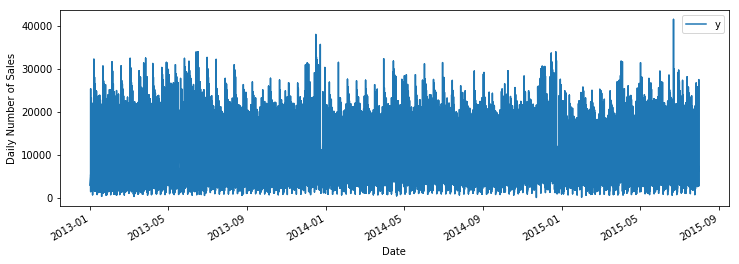

In [86]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [87]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet(interval_width= 0.95,
               holidays = state)

model.fit(sales)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [88]:
# dataframe that extends into future next 30 days
FutureDates = model.make_future_dataframe(periods = 30)

print("Last week to forecast.")
FutureDates.tail(7)

Last week to forecast.


ds
457065 2015-08-24
457066 2015-08-25
457067 2015-08-26
457068 2015-08-27
457069 2015-08-28
457070 2015-08-29
457071 2015-08-30

In [89]:
# predictions
forecast = model.predict(FutureDates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds         yhat   yhat_lower    yhat_upper
457065 2015-08-24  8314.535511  2271.925780  14350.366816
457066 2015-08-25  7257.148443  1192.085284  13549.430354
457067 2015-08-26  6773.750297   472.632687  12620.426409
457068 2015-08-27  6774.718743   961.700136  12655.833005
457069 2015-08-28  6935.998859  1193.166102  13113.962563
457070 2015-08-29  5216.073968  -705.837667  11527.500676
457071 2015-08-30  2676.765620 -3338.887226   9125.668740

In [90]:
fc = forecast[['ds', 'yhat']]

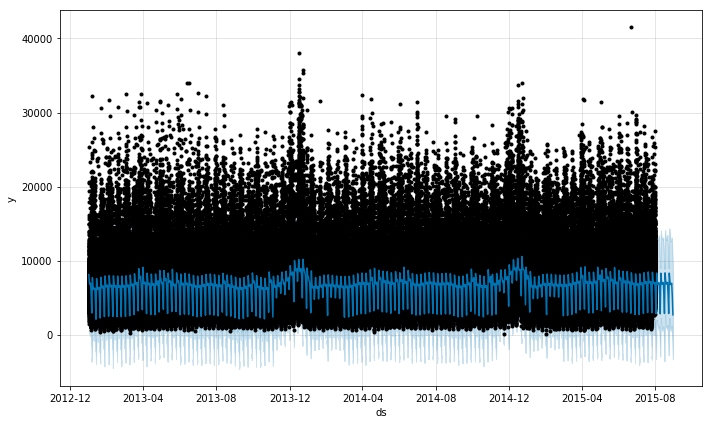

In [91]:
# visualizing predicions
model.plot(forecast);

**Note: **Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

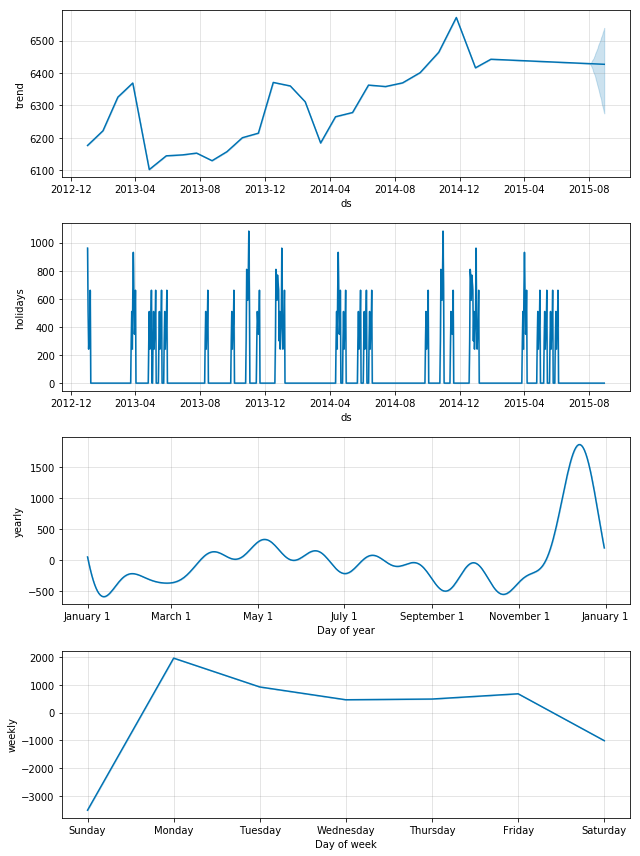

In [92]:
model.plot_components(forecast);

**Discussion: **The four plots show overall yearly, yearly, weekly, and holiday trends. The first plot shows that for store 7, there is an upward trend year on year. The second plot shows the holiday gaps included in the model. The third plot shows the yearly trend. Specifically, we see that there are two peak season for sales. The first between July and September, the second over Christmas. The final plot is a weekday trend showing that most of the sales happen on Monday, then slowly decreasing through the week.


### Diagnostic

In [93]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '660 days', period = '30 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2014-11-03 00:00:00 and 2015-05-02 00:00:00


ds         yhat   yhat_lower    yhat_upper      y     cutoff
0 2014-11-04  6815.795921   222.096312  12918.460808   5228 2014-11-03
1 2014-11-04  6815.795921  1088.986811  12843.132883   9994 2014-11-03
2 2014-11-04  6815.795921   690.129197  12534.915653   8933 2014-11-03
3 2014-11-04  6815.795921   816.996334  12789.641255  12731 2014-11-03
4 2014-11-04  6815.795921   718.701624  13100.622426  10710 2014-11-03

In [94]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse          mae      mape  coverage
179080 10 days  1.138434e+07  3374.068139  2566.289661  0.435785  0.934109
179081 10 days  1.138428e+07  3374.059536  2566.265981  0.435780  0.934109
179082 10 days  1.138436e+07  3374.072246  2566.280368  0.435755  0.934109
179083 10 days  1.138428e+07  3374.060367  2566.229224  0.435737  0.934109
179084 10 days  1.138444e+07  3374.083349  2566.278708  0.435748  0.934109

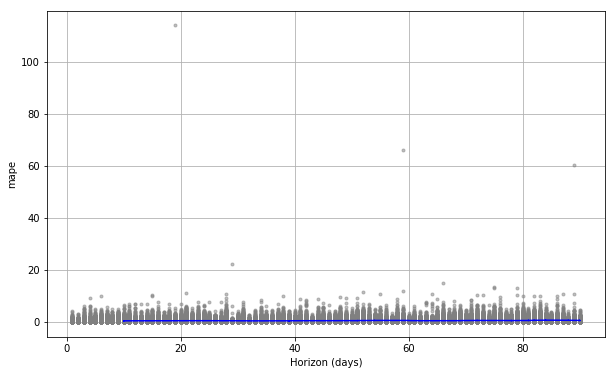

In [95]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

**Note: ** As we predicted, this model will be quite poor. But here, we can see that there are a few outliers that may be the problem. To rectify this, let's take the log of sales.

### np.log()

In [91]:
sales1 = sales.reset_index()
sales1.head(2)

Date  Sales
0 2015-07-31   6064
1 2015-07-30   5567

In [94]:
# sales1[sales1['Sales'] ==0]

In [95]:
sales1['Sales'] = np.log(sales1['Sales'])

In [96]:
sales1.columns = ['ds', 'y']

In [97]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet(interval_width= 0.95,
               holidays = state)

model.fit(sales1)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [98]:
# dataframe that extends into future next 30 days
FutureDates = model.make_future_dataframe(periods = 30)

print("Last week to forecast.")
FutureDates.tail(7)

Last week to forecast.


ds
457065 2015-08-24
457066 2015-08-25
457067 2015-08-26
457068 2015-08-27
457069 2015-08-28
457070 2015-08-29
457071 2015-08-30

In [99]:
# predictions
forecast = model.predict(FutureDates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds      yhat  yhat_lower  yhat_upper
457065 2015-08-24  8.940512    8.107286    9.746086
457066 2015-08-25  8.814244    7.983576    9.610227
457067 2015-08-26  8.753067    7.872818    9.553160
457068 2015-08-27  8.755157    7.928683    9.643578
457069 2015-08-28  8.782703    7.953209    9.618907
457070 2015-08-29  8.440774    7.599938    9.266003
457071 2015-08-30  7.840764    7.013457    8.677958

In [100]:
fc = forecast[['ds', 'yhat']]

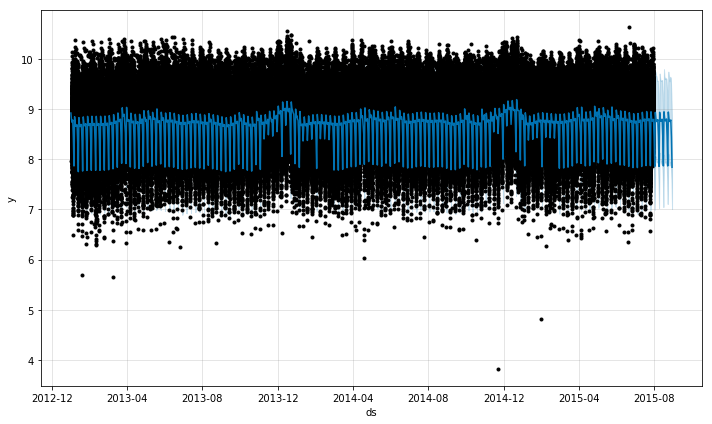

In [101]:
# visualizing predicions
model.plot(forecast);

**Note: **Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

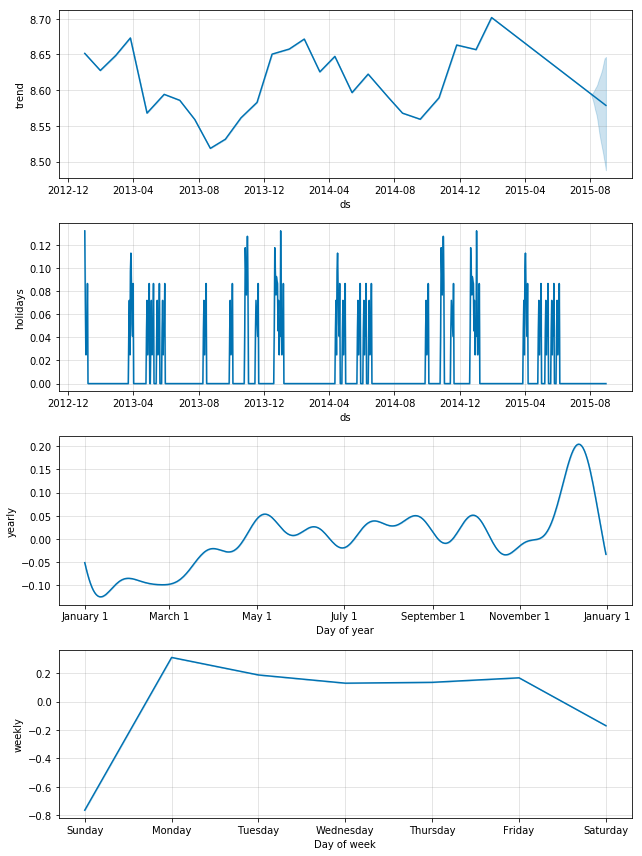

In [102]:
model.plot_components(forecast);

**Discussion: **The four plots show overall yearly, yearly, weekly, and holiday trends. The first plot shows that for store 7, there is an upward trend year on year. The second plot shows the holiday gaps included in the model. The third plot shows the yearly trend. Specifically, we see that there are two peak season for sales. The first between July and September, the second over Christmas. The final plot is a weekday trend showing that most of the sales happen on Monday, then slowly decreasing through the week.

### Diagnostic

In [103]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '660 days', period = '30 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2014-11-03 00:00:00 and 2015-05-02 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2014-11-04  8.736025    7.896657    9.552935  8.561784 2014-11-03
1 2014-11-04  8.736025    7.862699    9.548047  9.209740 2014-11-03
2 2014-11-04  8.736025    7.903451    9.498541  9.097508 2014-11-03
3 2014-11-04  8.736025    7.916704    9.555420  9.451795 2014-11-03
4 2014-11-04  8.736025    7.873885    9.534017  9.278933 2014-11-03

In [104]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape  coverage
179080 10 days  0.205416  0.453229  0.360078  0.041332  0.930087
179081 10 days  0.205416  0.453228  0.360075  0.041332  0.930087
179082 10 days  0.205402  0.453213  0.360066  0.041330  0.930087
179083 10 days  0.205399  0.453210  0.360056  0.041329  0.930087
179084 10 days  0.205400  0.453211  0.360059  0.041329  0.930087

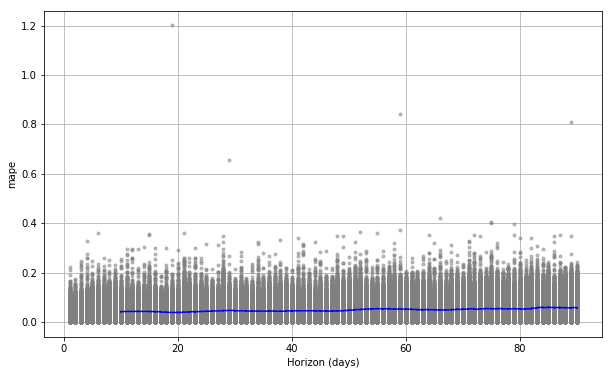

In [105]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

**Note: ** That looks much better. We have a mape of 4.1%, indicating that our model much better represents our data this time.

_____

### StoreType B

In [96]:
import numpy as np
# SalesB_log = np.log(Sales_B)

In [97]:
# from statsmodels.tsa.stattools import adfuller
# def test_stationarity(timeseries):
#     # detrmine rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window = 12)
#     rolstd = pd.rolling_std(timeseries, window = 12)
    
#     #plot rolling statistics:
#     orig = plt.plot(timeseries, color='blue', label = 'Original')
#     mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
#     std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')

#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
#     #Perform Dickey-Fuller test:
#     print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
#                                              '#Lags Used', 'Number of Obsevations Used'])
    
#     for key, value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)

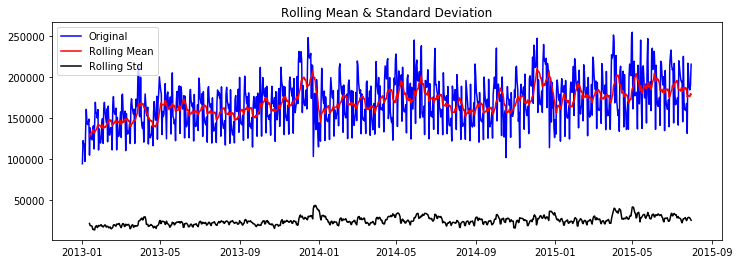

Results of Dickey-Fuller Test:
Test Statistic                 -3.739137
p-value                         0.003595
#Lags Used                     21.000000
Number of Obsevations Used    920.000000
Critical Value (1%)            -3.437478
Critical Value (5%)            -2.864687
Critical Value (10%)           -2.568445
dtype: float64


In [98]:
test_stationarity(Sales_B.resample('D').sum())

Looks like it passed the dickey fuller test.

In [99]:
data = pd.DataFrame(Sales_B.resample('D').sum()).reset_index()
data.columns = ['ds', 'y']
data.head()

ds       y
0 2013-01-01   94328
1 2013-01-02  122421
2 2013-01-03  117817
3 2013-01-04  117878
4 2013-01-05   97208

In [100]:
# create holidays dataframe
state_dates = train[(train.StateHoliday == 'a') | (train.StateHoliday == 'b') | (train.StateHoliday == 'c')].loc[:, 'Date'].values
# school_dates = train[train.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates),
                      'lower_window': -5,
                      'upper_window': 0
                     })
# school = pd.DataFrame({'holiday': 'school_holiday',
#                       'ds': pd.to_datetime(school_dates),
# #                       'lower_window': -5,
# #                       'upper_window': 0
#                       })

# holidays = pd.concat((state, school))      
# holidays.head()

In [101]:
model=Prophet(interval_width = 0.95, 
                   holidays = state)
model.fit(data)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [102]:
future=model.make_future_dataframe(periods = 90)
future.tail(7)

ds
1025 2015-10-23
1026 2015-10-24
1027 2015-10-25
1028 2015-10-26
1029 2015-10-27
1030 2015-10-28
1031 2015-10-29

In [103]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
1027 2015-10-25  199271.908173  163738.314847  233721.933609
1028 2015-10-26  191361.808606  154384.806178  226171.978053
1029 2015-10-27  178175.851990  143198.983956  209524.632935
1030 2015-10-28  175686.401405  140347.401275  209822.224138
1031 2015-10-29  177155.777054  141341.707733  211433.397816

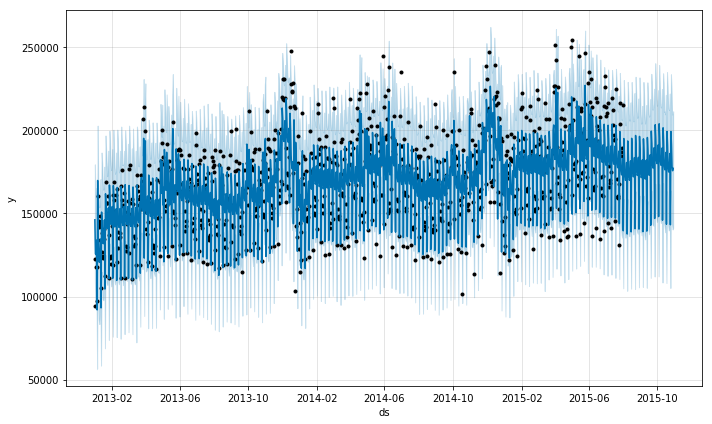

In [104]:
fig1 = model.plot(forecast)

In [105]:
# forecast[(forecast['state'] + forecast['school']).abs() > 0]\
# [['ds', 'state', 'school']][-10:]

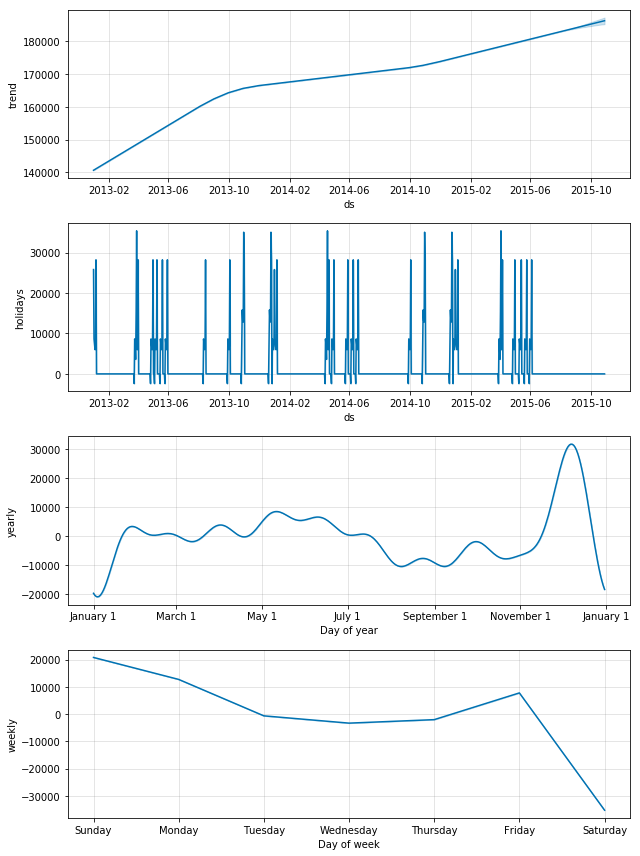

In [106]:
fig2 = model.plot_components(forecast)

**Observations: **
* There plots show that there is a general upward trend for sales for StoreType B 
* Holidays positively impact sales trend
* There is a huge boost in sales just before Christmas
* Saturdays are the worst day for sales for this StoreType whereas Sunday, Monday, and Fridays (in that order) positively impact sales

### Diagnostic

In [107]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '660 days', period = '30 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2014-11-03 00:00:00 and 2015-05-02 00:00:00


ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2014-11-04  165912.384570  131983.630972  197929.315044  194106 2014-11-03
1 2014-11-05  164903.174928  131733.828718  198019.333624  185128 2014-11-03
2 2014-11-06  166885.947157  132385.421046  202130.131906  145930 2014-11-03
3 2014-11-07  176054.748252  140712.460058  210659.245060  156844 2014-11-03
4 2014-11-08  135248.013048  102239.249504  168512.798678  113665 2014-11-03

In [108]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse          rmse           mae      mape  coverage
8    9 days  4.242805e+08  20598.071179  18011.106142  0.102940  0.888889
279 10 days  4.127220e+08  20315.560724  17693.216310  0.101427  0.888889
99  10 days  4.060848e+08  20151.545183  17525.426270  0.101032  0.888889
189 10 days  4.220617e+08  20544.139522  17903.506742  0.102994  0.888889
459 10 days  4.229196e+08  20565.009418  18009.683500  0.103506  0.888889

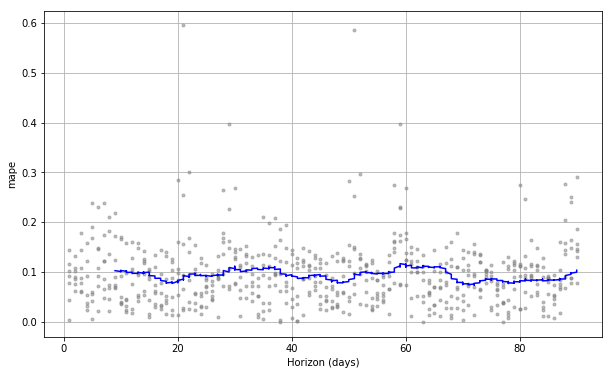

In [109]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

____

### StoreType C

In [110]:
data = pd.DataFrame(Sales_C.resample('D').sum()).reset_index()
data.columns = ['ds', 'y']
data.head()

ds       y
0 2013-01-02  936789
1 2013-01-03  839158
2 2013-01-04  889459
3 2013-01-05  914875
4 2013-01-06       0

In [111]:
data = data[data['y'] > 0]

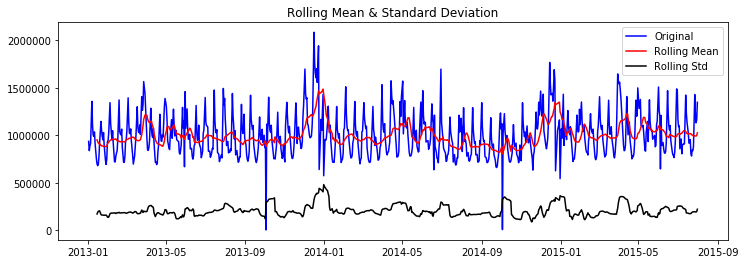

Results of Dickey-Fuller Test:
Test Statistic                 -4.946720
p-value                         0.000028
#Lags Used                     18.000000
Number of Obsevations Used    767.000000
Critical Value (1%)            -3.438905
Critical Value (5%)            -2.865316
Critical Value (10%)           -2.568781
dtype: float64


In [112]:
test_stationarity(data.set_index('ds')['y'])

In [113]:
data['y'].min()

3681

In [114]:
model=Prophet(interval_width = 0.95, 
                   holidays = state)
model.fit(data)

future=model.make_future_dataframe(periods = 90)
future.tail(7)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
869 2015-10-23
870 2015-10-24
871 2015-10-25
872 2015-10-26
873 2015-10-27
874 2015-10-28
875 2015-10-29

In [115]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat     yhat_lower    yhat_upper
871 2015-10-25  9.388981e+05  565457.665089  1.313130e+06
872 2015-10-26  1.116356e+06  744792.917242  1.509592e+06
873 2015-10-27  9.621391e+05  586264.211841  1.342111e+06
874 2015-10-28  9.170593e+05  560571.429775  1.307332e+06
875 2015-10-29  9.304376e+05  566829.946081  1.280187e+06

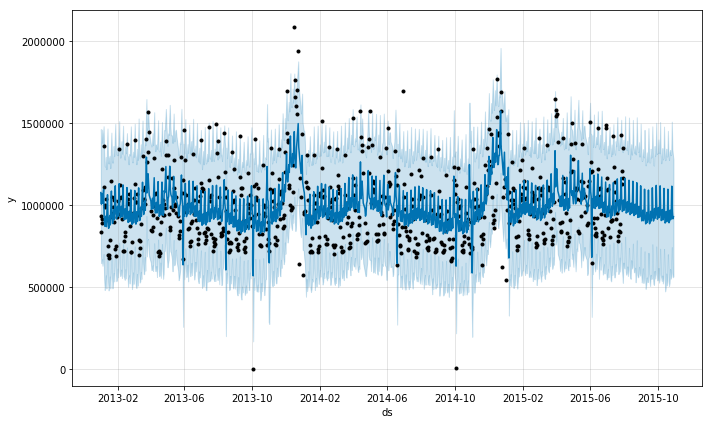

In [116]:
fig1 = model.plot(forecast)

In [117]:
data.min()

ds    2013-01-02 00:00:00
y                    3681
dtype: object

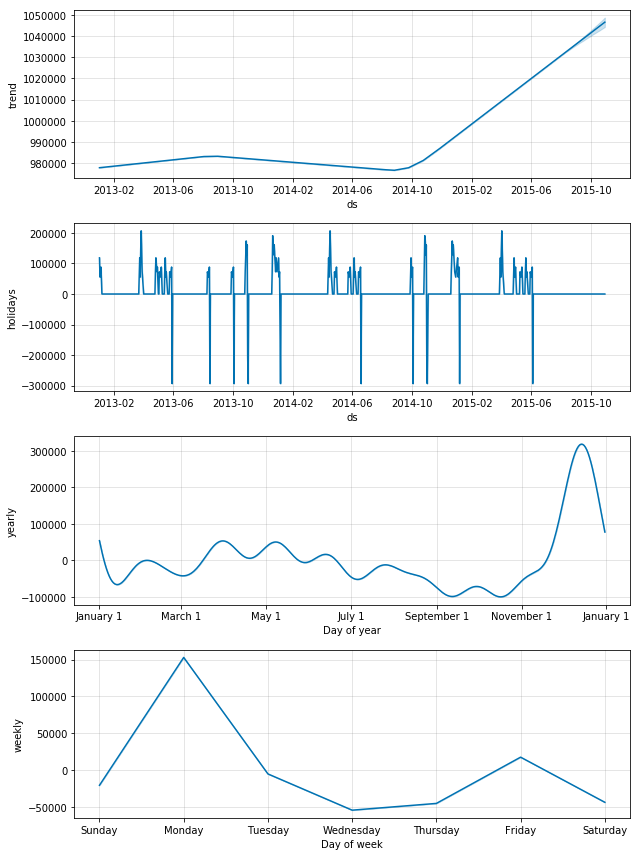

In [118]:
fig2 = model.plot_components(forecast)

**Note: ** For this store type, we see that holidays negatively affect sales. Furthermore, Mondays tend to the biggest postitive impact on sales.

### Diagnostic

In [119]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '660 days', period = '30 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2014-11-03 00:00:00 and 2015-05-02 00:00:00


ds           yhat     yhat_lower    yhat_upper        y     cutoff
0 2014-11-04  894100.683295  543982.646417  1.277143e+06  1134392 2014-11-03
1 2014-11-05  868842.553641  514495.302552  1.241052e+06  1039713 2014-11-03
2 2014-11-06  871023.975828  494315.419855  1.264746e+06   987083 2014-11-03
3 2014-11-07  936834.575141  579795.254435  1.302579e+06  1035280 2014-11-03
4 2014-11-08  881233.531566  505883.230593  1.264182e+06   926852 2014-11-03

In [120]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse           rmse            mae      mape  coverage
307  9 days  4.480998e+10  211683.684779  173713.865507  0.176203  0.882353
7    9 days  4.370110e+10  209048.081957  169677.801372  0.172782  0.882353
8   10 days  4.292337e+10  207179.551049  166608.024911  0.170117  0.882353
451 10 days  4.453983e+10  211044.612437  172126.015777  0.176757  0.882353
233 10 days  4.460375e+10  211196.004964  172524.465419  0.177818  0.882353

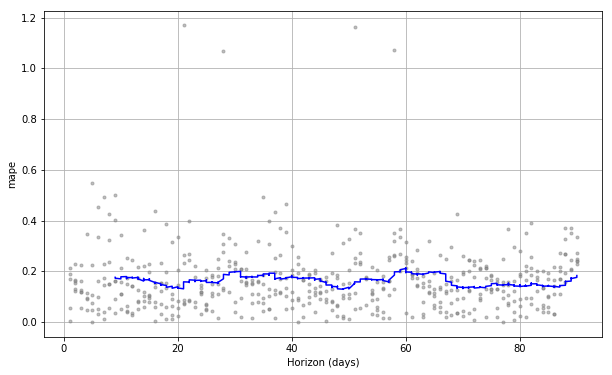

In [121]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

____

### StoreType D

In [113]:
data = pd.DataFrame(Sales_D.resample('D').sum()).reset_index()
data.columns = ['ds', 'y']
data.head()

ds        y
0 2013-01-02  1970233
1 2013-01-03  1862818
2 2013-01-04  2021402
3 2013-01-05  1974923
4 2013-01-06     3395

In [114]:
data = data[data['y']!=0]

In [115]:
data1 = data[data['y'] > 2*(data['y'].mean() - data['y'].std())]

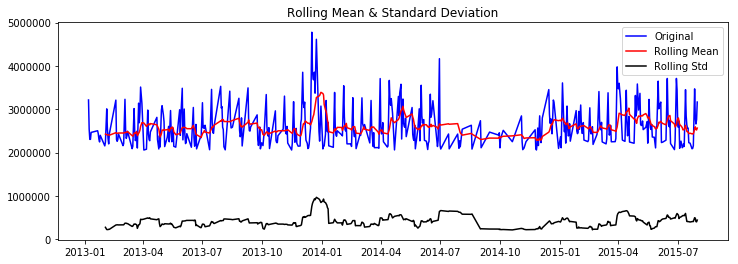

Results of Dickey-Fuller Test:
Test Statistic               -9.259381e+00
p-value                       1.420671e-15
#Lags Used                    4.000000e+00
Number of Obsevations Used    4.500000e+02
Critical Value (1%)          -3.444966e+00
Critical Value (5%)          -2.867984e+00
Critical Value (10%)         -2.570203e+00
dtype: float64


In [116]:
test_stationarity(data1.set_index('ds')['y'])

In [117]:
print(data['y'].min())
print(data['y'].max())
print(data['y'].median())

1800
4777323
2059185.0


In [118]:
model=Prophet(interval_width = 0.95, 
                   holidays = state)
model.fit(data1)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [119]:
future=model.make_future_dataframe(periods = 90)
future.tail(7)

ds
538 2015-10-23
539 2015-10-24
540 2015-10-25
541 2015-10-26
542 2015-10-27
543 2015-10-28
544 2015-10-29

In [120]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
540 2015-10-25  3.084752e+06  2.461093e+06  3.692562e+06
541 2015-10-26  3.172322e+06  2.570562e+06  3.729393e+06
542 2015-10-27  2.650122e+06  2.062322e+06  3.248449e+06
543 2015-10-28  2.535201e+06  1.942645e+06  3.138615e+06
544 2015-10-29  2.544706e+06  2.015440e+06  3.174405e+06

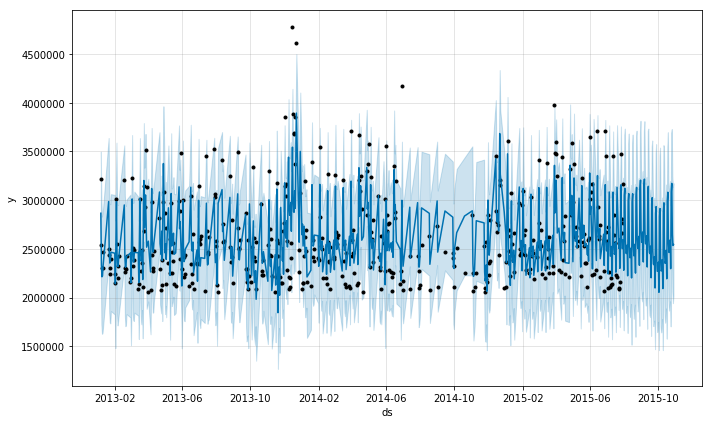

In [121]:
fig1 = model.plot(forecast)

In [122]:
# forecast[(forecast['state'] + forecast['school']).abs() > 0]\
# [['ds', 'state', 'school']][-10:]

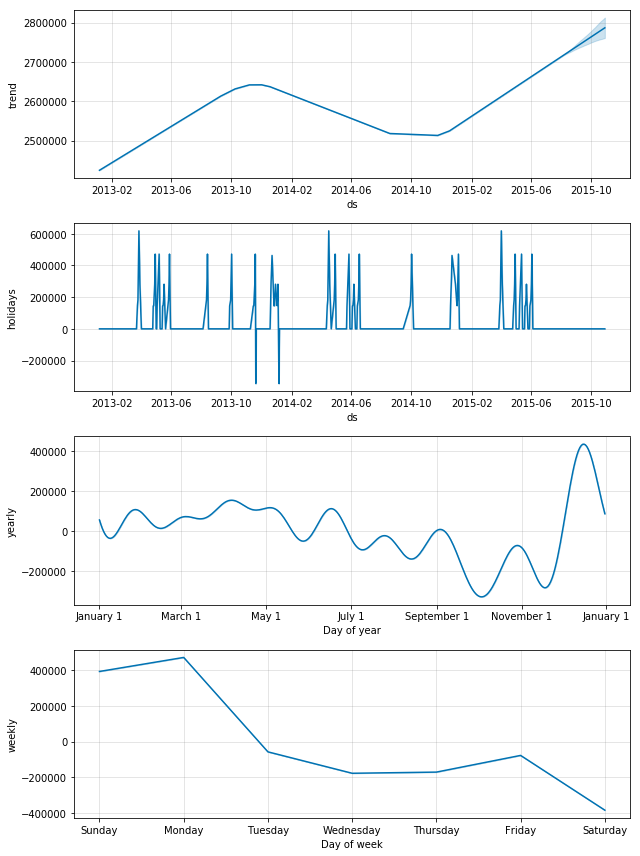

In [123]:
fig2 = model.plot_components(forecast)

**Observastions: ** 
* Here, again, holidays seem to negatively impact sales. 
* We see a very similar yearly trend as StoreType C, but the pattern is more more pronounced. 
* We see a small bump in sales peak between  April/ May, and a much bigger boost over the Christmas period. 
* Then sales tend to stay quite until at least October
* Weekly trend reveals that Sundays and Mondays positively affect sales

### Diagnostic

In [124]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '660 days', period = '90 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 2 forecasts with cutoffs between 2014-11-03 00:00:00 and 2015-02-01 00:00:00


ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2014-11-04  2.239000e+06  1.613222e+06  2.853139e+06  2253195 2014-11-03
1 2014-11-05  2.136414e+06  1.533225e+06  2.768405e+06  2066614 2014-11-03
2 2014-11-07  2.207867e+06  1.613906e+06  2.814118e+06  2104266 2014-11-03
3 2014-11-10  2.749608e+06  2.125618e+06  3.359714e+06  2251629 2014-11-03
4 2014-11-24  2.595501e+06  1.957511e+06  3.233715e+06  2525642 2014-11-03

In [125]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()


horizon           mse           rmse            mae      mape  coverage
5 22 days  4.182664e+10  204515.623603  173336.749157  0.071304       1.0
6 23 days  4.230302e+10  205676.986544  177558.816054  0.073384       1.0
7 24 days  4.433765e+10  210565.072534  183737.754949  0.076894       1.0
8 25 days  5.601899e+10  236683.307214  204665.917980  0.084723       1.0
9 26 days  6.044339e+10  245852.366590  212368.969623  0.089169       1.0

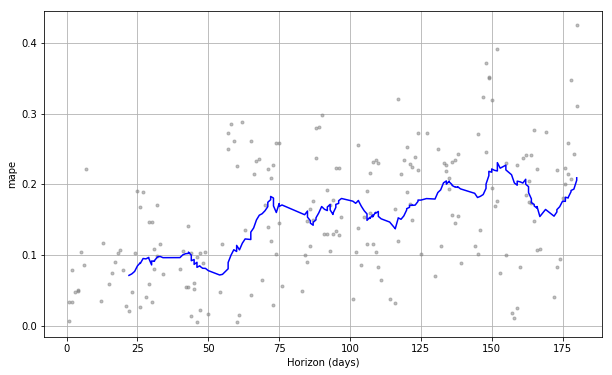

In [126]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

___

### Store 7 - Storetype A

In [136]:
# TrainStore[TrainStore['StoreType'] == 'a']


In [137]:
data = TrainStore[TrainStore['Store'] == 7]['Sales']

In [138]:
data= pd.DataFrame(data).reset_index()

In [139]:
data.columns = ['ds', 'y']
data.head()

ds      y
0 2015-07-31  15344
1 2015-07-30  11560
2 2015-07-29  12074
3 2015-07-28  12342
4 2015-07-27  14869

In [140]:
data = data[data['y']!=0]


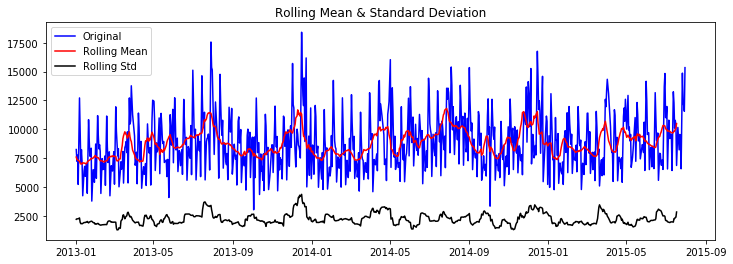

Results of Dickey-Fuller Test:
Test Statistic                 -5.118214
p-value                         0.000013
#Lags Used                     13.000000
Number of Obsevations Used    772.000000
Critical Value (1%)            -3.438849
Critical Value (5%)            -2.865291
Critical Value (10%)           -2.568767
dtype: float64


In [141]:
test_stationarity(data.set_index('ds')['y'])


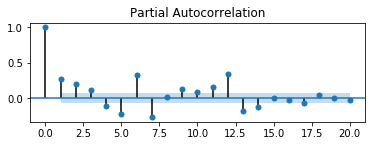

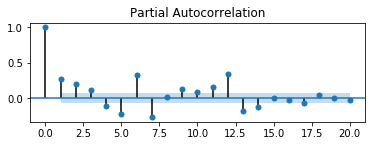

In [142]:
plt.figure(figsize = (6, 4))

plt.subplot(111); plot_acf(data['y'], lags = 20, ax = plt.gca())
plt.subplot(211); plot_pacf(data['y'], lags = 20, ax = plt.gca())


In [143]:
model=Prophet(interval_width = 0.95, 
                   holidays = state)
model.fit(data)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [144]:
future=model.make_future_dataframe(periods = 90)
future.tail(7)

ds
869 2015-10-23
870 2015-10-24
871 2015-10-25
872 2015-10-26
873 2015-10-27
874 2015-10-28
875 2015-10-29

In [145]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat   yhat_lower    yhat_upper
871 2015-10-25   8102.682916  4773.890939  11131.556660
872 2015-10-26  10109.913962  6707.238926  13336.811755
873 2015-10-27   9114.686625  5990.854687  12256.851420
874 2015-10-28   7763.535783  4345.288977  11095.492146
875 2015-10-29   7904.567338  4505.125826  11457.539937

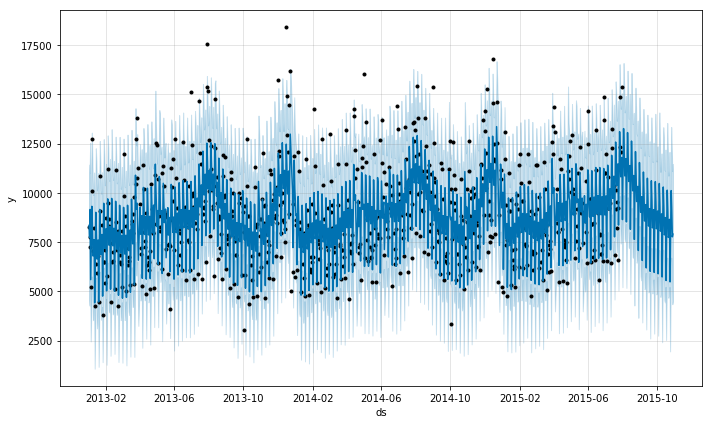

In [146]:
fig1 = model.plot(forecast)


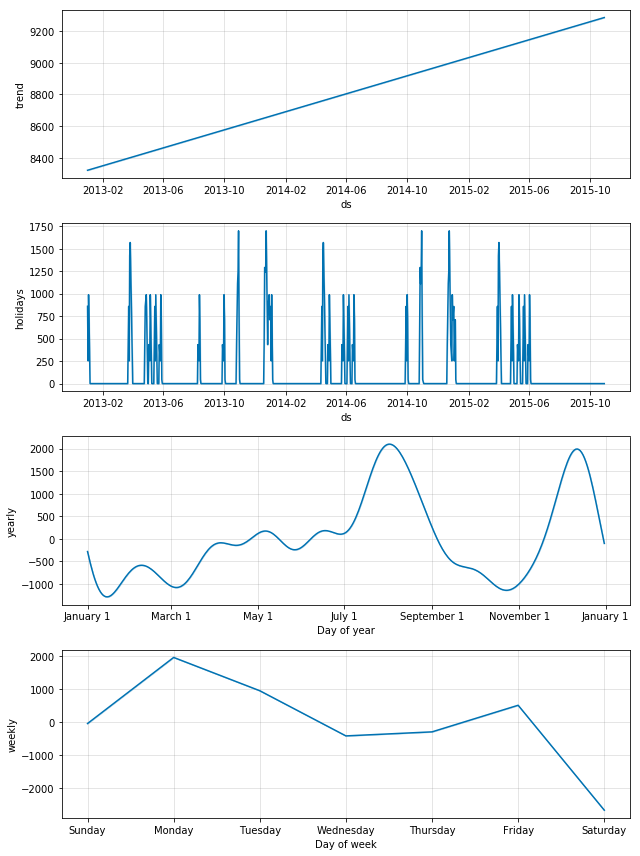

In [147]:
# forecast[(forecast['state'] + forecast['school']).abs() > 0]\
# [['ds', 'state', 'school']][-10:]

fig2 = model.plot_components(forecast)

**Observations: ** 
* Here, again, holidays seem to negatively impact sales. 
* We see a very similar yearly trend as StoreType C, but the pattern is more more pronounced. 
* We see peaks between late march/early April, late April/early May, and mid June. 
* Then sales tend to stay quite until at least October
* We see another dip mid-Oct, and we see the Christmas sales again later in the year
* Weekly trend reveals that Mondays and Tuesdays positive affects sales 

### Diagnostic

In [148]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '660 days', period = '90 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 2 forecasts with cutoffs between 2014-11-03 00:00:00 and 2015-02-01 00:00:00


ds         yhat   yhat_lower    yhat_upper      y     cutoff
0 2014-11-04  8998.668719  5813.623958  12438.179258  11121 2014-11-03
1 2014-11-05  7802.511623  4583.614955  11009.968554   8842 2014-11-03
2 2014-11-06  7889.876682  4510.698690  11038.794976   9743 2014-11-03
3 2014-11-07  8715.879164  5436.594217  11873.627555  10087 2014-11-03
4 2014-11-08  5596.699474  2528.735672   8987.513581   6506 2014-11-03

In [149]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse          mae      mape  coverage
163 17 days  1.520862e+06  1233.232149  1049.798299  0.118609       1.0
14  17 days  1.428218e+06  1195.080882  1023.104033  0.118421       1.0
164 18 days  1.355664e+06  1164.329696   988.950623  0.116217       1.0
15  18 days  1.410656e+06  1187.710346  1008.999746  0.120004       1.0
16  19 days  1.376852e+06  1173.393474   984.072315  0.117752       1.0

In [150]:
print("max sales: {}".format(data['y'].max()))
print("min sales: {}".format(data['y'].min()))
print('mean sales: {}'.format(data['y'].mean()))
print("median sales: {}".format(data['y'].median()))

max sales: 18413
min sales: 3020
mean sales: 8817.050890585242
median sales: 8494.0


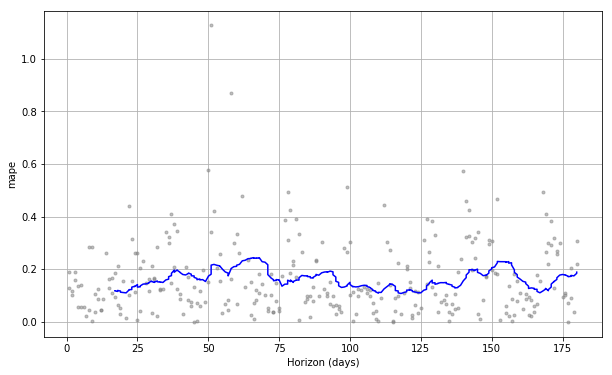

In [151]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

____

# General Discussion

In this project, I first conducted exploratory data analysis to get a better understanding of the data. Then I used time ARIMA and Prophet to conduct a time series analysis to forecast sales trends for Rossmann stores. Using auto_arima across all stores failed to provide accurate forecast for store sales. Even though mape was around 16%, the model failed to capture patterns in the dataset. One possible explanation for this is that holidays were not accounted for in the ARIMA model. To addres this, I used Prophet to see if I can improve the model. Using Prophet on the entire dataset did not produce any better results; infact the error rate increased to 46%!! Perhaps another way to address this would be to look at each store type separately. It is possible that there was too much noise when looking at all storetypes together. 

Looking at each storetype differently revealed storetype specific patterns. While mape for storetypes a and c did not significantly improve, mape for storetype b and d decreased from 16% to 4% and 8% respectively. This is a drastic improvement. While for each storetype the error rate is acceptable, more can be done to improve the model. Having regional information, knowing local deomographic/celebrations, population density, geography, and weather patterns can work to significantly improve the model. 